**Q8.1**

In [ ]:
from numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io
from pandas.core.series import reshape
from scipy import stats
import math
mnist = np.load(f"/Users/zhiwang/Downloads/hw3-2023/data/mnist-data-hw3.npz")
mnist_train, mnist_labels = mnist['training_data'].reshape((60000, 28 * 28)), mnist['training_labels']

# normalize is to divide the pixel values of an image by the l2-norm of its pixel values.
l2 = norm(mnist_train, 2)
norm_train2 = mnist_train /l2
norm_train2

labels = np.unique(mnist_labels)
mean= {}
covar = {}
for label in labels:
    single_digit = mnist_train[mnist_labels == label]
#fit a Gaussian distribution to each digit class using maximum likelihood estimation.
    mean_digit = np.mean(single_digit)
    sigma = np.cov(single_digit.T)
    mean[label] =  mean_digit
    covar[label] = sigma


**Q8.2**

Visualize the covariance matrix for digit 7.

The diagonal terms are larger than the off-diagonal trems. Each element on the principal diagonal of a correlation matrix is the correlation of a random variable with itself, which always equals 1. Each off-diagonal element is between −1 and +1 inclusive.

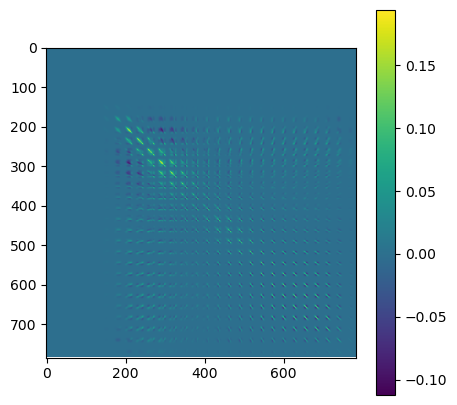

In [ ]:
# image
#digit_7 = mnist_train[mnist_labels == 7]
fig= plt.figure(figsize=(5,5))
plt.imshow(covar[7])
plt.colorbar()
plt.show()

**Q8.3(a)**
Linear discriminant analysis (LDA)

In [ ]:
import numpy.linalg
from scipy.stats import multivariate_normal
mnist_train = mnist["training_data"].reshape((60000, 28 * 28))
index = np.random.permutation(mnist["training_data"].shape[0]) # shuffle training index
norm_training = mnist_train/norm(mnist_train, 2) #(mnist_train - np.mean(mnist_train))/np.std(mnist_train) #
mnist_X, mnist_val_X = norm_training[index ][:50000], norm_training[index][50000:] # split training set after shuffle
mnist_y, mnist_val_y = mnist['training_labels'][index][:50000], mnist['training_labels'][index][50000:]


In [ ]:
# Function for get the mean, prior covariance for each label and poolde covariance
def mean_prior_cov(X,y):
    d = X.shape[1]
    n = X.shape[0]
    covar = np.zeros((10,d,d))
    sigma = np.zeros((d,d))
    pool_cov = np.zeros((d, d))
    labels= np.unique(y)
    mean = np.zeros((len(labels),d))
    prior =  np.zeros((10,1))
    for  label in labels:
        # mean
        classes = X[y == label]
        mean_digit= np.mean(classes,axis=0)
        mean[label] =  mean_digit
        # prior
        prior[label] =  np.sum(X[y == label].shape[0])/X.shape[0]
        sigma  = np.cov(classes.T)
        # Covar Matrix for each label
        covar[label] =sigma
        pool_cov = np.add(pool_cov,sigma)

    # Pooled cov for LDA
    pool_cov = pool_cov/10  + (1e-12 * np.eye(d))
    return mean, prior,covar,pool_cov

In [ ]:
# LDA Model, result the predict value for the validation set
def lda(x_train,y_train,x_val,num):

    X_train,Y_train = x_train[:num],y_train[:num]
    mean, prior,covar,pool_cov= mean_prior_cov(X_train,Y_train)
    labels =np.unique(y_train)
    L =np.zeros((len(labels),x_val.shape[0]))

    for label in labels:
        L[label,:]=multivariate_normal.logpdf(x_val, allow_singular=True, cov=pool_cov, mean=mean[label])
        L[label,:] += np.log(prior[label])
    pred = np.argmax(L.T,axis =1)

    return pred

In [ ]:
# For Calculation the validation accuracy for select model
def accuracies(x_train,y_train,x_val,y_val,num,model):
    predict =  model(x_train[:num],y_train[:num],x_val,num)
    return np.sum(predict == y_val)/x_val.shape[0]

In [ ]:
# Function for record the training and validation accuracy history.
def error_his(X_train, y_train,x_val,y_val, num_list,f):
  error_rate= []
  for i in num_list:
    val_acc =1- accuracies(X_train,y_train,x_val,y_val,i,f)
    error_rate.append(val_acc)
  return error_rate
#accuracies(x_train,y_train,x_val,y_val,num,f)

In [ ]:
# Function for making the plot of the error rates
def make_plot(train_his,data_name, train_num):
  plt.figure(figsize=[4,4])
  plt.plot( train_num,train_his,'b',linewidth=3.0)
  plt.legend(['Error Rate'],fontsize=18)
  plt.xlabel('Number of Training Examples  ',fontsize=16)
  plt.ylabel('Error Rate',fontsize=16)
  plt.title(data_name,fontsize=16)


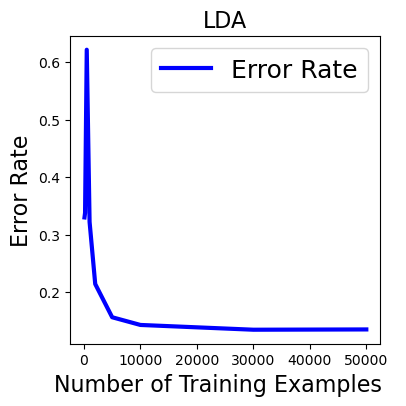

In [ ]:
train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
lda_his =error_his(mnist_X,mnist_y,mnist_val_X , mnist_val_y, train_sizes,lda)
make_plot(lda_his,"LDA", train_sizes)

**Q8.3(b)**
Quadratic discriminant analysis (QDA)

In [ ]:
# QDA function , result the prediction of the validation set
def qda(x_train,y_train,x_val,num):
    X_train,Y_train = x_train[:num],y_train[:num]
    mean, prior,covar,pool_cov= mean_prior_cov(X_train,Y_train)
    labels =np.unique(y_train)
    L =np.zeros((len(labels),x_val.shape[0]))

    for label in labels:
        L[label,:]=multivariate_normal.logpdf(x_val, allow_singular=True, cov=covar[label], mean=mean[label])
        L[label,:] += np.log(prior[label])
    pred = np.argmax(L.T,axis =1)

    return pred

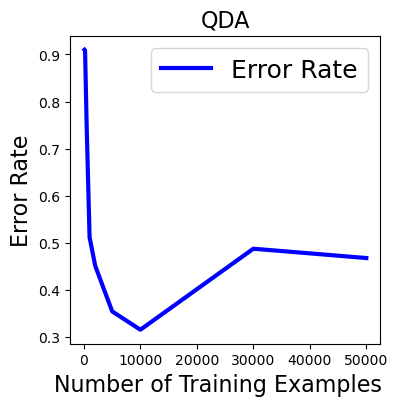

In [ ]:
qda_his = error_his(mnist_X,mnist_y,mnist_val_X , mnist_val_y, train_sizes,qda)
make_plot(qda_his,"QDA", train_sizes)

**Q8.3(c)**
QDA performs slightly better due to more flexible boundaries.  QDA has the lowest error rate at 10000 training point, but the error rate will slightly increase with the larger the training set, which may be the result of overfitting.

**Q8.3(d)**

For LDA, digit 1 is easiest to classify, and for QDA digit 2 is easiest to classify.

In [ ]:
# Function for record the training and validation accuracy history.
def predtion_list(f):
    pred_list = []
    for num in train_sizes:
        prediction = f(mnist_X,mnist_y, mnist_val_X,num)
        pred_list.append(prediction)
    return pred_list


In [ ]:
def digit_error_plot(pred_list,name):
    error = {}
    for pred in pred_list:
        for digit in range(0, 10):
            digit_pred = pred[mnist_val_y == digit]
            labels = mnist_val_y[mnist_val_y == digit]
            error[digit] = error.get(digit, []) + [(digit_pred == labels).mean()]

    fig, axes = plt.subplots(1, 1, figsize=(4, 4))
    for digit in error.keys():
        axes.plot(train_sizes, [1 - x for x in error[digit]])

    axes.legend([f"Digit {x}" for x in list(range(0, 10))], loc='upper right')
    axes.set_title(name+ " Validation Error Rate vs. Training Points")
    axes.set_xlabel("Training Points")
    axes.set_ylabel("Validation Error Rate")
    plt.show()

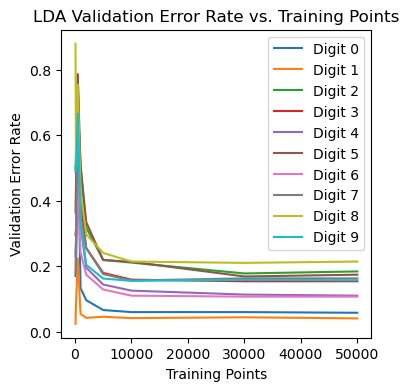

In [ ]:
digit_error_plot(predtion_list(lda),'LDA')

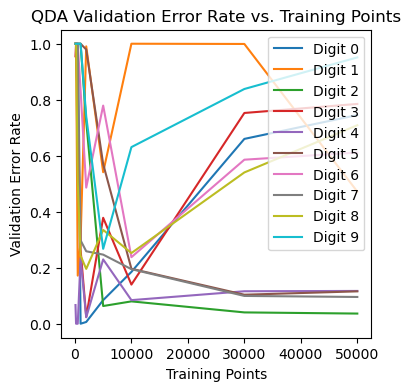

In [ ]:
digit_error_plot(predtion_list(qda),'QDA')

**Q8.4**

kaggle username: zwang108
MNIST score:  0.85933

For get better prediction result, I have train the dataset on the LDA model with all Mnist training set.

In [ ]:
# Usage: results_to_csv(clf.predict(X_test))
# this part of code from hw1/scripts/save_csv.py
import pandas as pd
def results_to_csv(y_test,name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv(name+'_submission.csv', index_label='Id')

In [ ]:
mnist_test = mnist["test_data"].reshape((10000, 28 * 28))
mnist_test_norm=mnist_test /norm(mnist_test, 2)
mnist_test_norm.shape

(10000, 784)

In [ ]:
# Result MNIST test prediction to csv file
results_to_csv(lda(mnist_X,mnist_y,mnist_test_norm,50000), 'MNIST ')


**Q8.5**

kaggle username: zwang108

Spam score: 0.792

***Code Appendix : featurize.py , save_csv.py***

1. For get better prediction result, I have train the dataset on the LDA model with all spam training set.

2. For improve the Spam dataset accuracy, I also modify [featurize.py]. There are some words is more often showing in spam emails, so I add some new features.


In [ ]:
np.random.seed(1)
spam = np.load(f"/Users/zhiwang/Downloads/hw3-2023/data/spam-data-bow.npz")
spam_shuffle = np.random.permutation(spam["training_data"].shape[0]) # shuffle training index
spam_trainsize = round(spam["training_data"].shape[0]*(1-0.15))
spam_training, spam_valing = spam["training_data"][:spam_trainsize], spam["training_data"][spam_trainsize:] # split training set after shuffle
spam_labling, spam_label_val = spam['training_labels'][spam_shuffle][:spam_trainsize], spam['training_labels'][spam_shuffle][spam_trainsize:] # split training label after shuffle
spam_test= spam["test_data"]
spam["test_data"].shape


(1000, 49)

In [ ]:
results_to_csv(lda(spam["training_data"],spam['training_labels'],spam_test,4172), 'Spam')